In [1]:
import os
import glob
import re
import time
import datetime
from string import punctuation
import itertools as it
import numpy as np
from imageio import imwrite
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parameter as P
from torch.utils.data import Dataset, DataLoader

import torch.nn.utils.rnn as utils_rnn

torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
np.random.seed(0)

# Sentence sampling

In [4]:
! cat ../data/task3_train.txt | wc -l

23011601


In [5]:
sample_lines = np.random.choice(np.arange(23011601), size=150000, replace=False)

In [6]:
sample_lines = np.sort(sample_lines)

In [6]:
sample_lines.shape

(150000,)

In [7]:
sample_lines[:10]

array([ 157,  181,  343,  609,  618,  655, 1115, 1132, 1151, 1296])

In [8]:
line_no = 0
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'w') as sample_data:
    with open('/home/md359230/DeepLearning/assignment3/data/task3_train.txt', 'r') as full_data:
        for counter, line in enumerate(full_data):
            if line_no < 150000 and counter == sample_lines[line_no]:
                line_no += 1
                max_word_length = max([len(word) for word in line.split()])
                correct_line = True if max_word_length <= 15 else False
                if correct_line:
                    sample_data.write(line)
            

In [9]:
print(line_no)

150000


In [10]:
! cat ../data/task3_sample.txt | wc -l

131723


In [12]:
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'r') as sample_data:
    with open('/home/md359230/DeepLearning/assignment3/data/train.txt', 'w') as train_data:
        with open('/home/md359230/DeepLearning/assignment3/data/validation.txt', 'w') as validation_data:
            for counter, line in enumerate(sample_data):
                if counter < 105378:
                    train_data.write(line)            
                else:
                    validation_data.write(line)


In [13]:
! cat ../data/train.txt | wc -l

105378


In [14]:
! cat ../data/validation.txt | wc -l

26345


# Preprocessing

In [4]:
class CorpusPreprocessor(object):  
    @staticmethod
    def transform_text(text):
        # Remove EOL character
        text = text.replace('\n', ' ')
        
        # Remove numbers
        numbers = '1234567890'
        for number in numbers:
            text = text.replace(number, ' ')
        
        # Remove punctuation
        for specialchar in punctuation:
            text = text.replace(specialchar, ' ')
            
        # Remove double spaces
        double_spaces = re.compile('\s+')
        text = re.sub(double_spaces, ' ', text)
        
        # Trim text
        words = text.split(' ')
        words = [word.lower() for word in words if word]
        text = ' '.join(words)
        
        return text
    
    @staticmethod
    def mask_text(text, corpus_dictionary):
        MASK = 'MASK'
        masked_sent = text.split()
        selected_word_idx = np.random.choice(len(masked_sent))
        if np.random.choice(2) == 1:
            original_word = masked_sent[selected_word_idx]
            masked_sent[selected_word_idx] = MASK
            return (masked_sent, original_word, 1)
        else:
            random_word = np.random.choice(corpus_dictionary)
            masked_sent[selected_word_idx] = MASK
            return (masked_sent, random_word, 0)

In [5]:
CorpusPreprocessor.transform_text('AFDafs  41 2 5$#sa 24 Sfw15 gw g4gfdsaf j.    ')

'afdafs sa sfw gw g gfdsaf j'

In [6]:
CorpusPreprocessor.mask_text(CorpusPreprocessor.transform_text('Ala ma kota.'), ['aaa', 'bbb', 'ccc'])

(['MASK', 'ma', 'kota'], 'ala', 1)

# Data loading

In [7]:
class NLPDataSet(Dataset):
    def __init__(self, file_path):
        self.sentences = []
        self.corpus_vocab = []
        
        # Load corpus from file
        chars = set()
        with open(file_path, 'r') as raw_data:
            for line in raw_data:
                line = CorpusPreprocessor.transform_text(line)
                chars = chars | set(line)
                self.sentences.append(line)
        
        # Create dict with all letters
        self.chars = OrderedDict(zip(chars, (torch.zeros(len(chars)) for _ in range(len(chars)))))
        for idx, key in enumerate(self.chars.keys()):
            if key != ' ':
                self.chars[key][idx] = 1.
        
        # Fill the dictionary with sample 20%
        for sentence in self.sentences[:len(self.sentences) // 5]:
            for word in sentence.split():
                if len(word) >= 3:
                    self.corpus_vocab.append(word)
    
    def __len__(self):
        return len(self.sentences)
    
    def _encode_word(self, word):
        result = []
        if word == 'MASK':
            return result
        
        for letter in word:
            result.append(self.chars[letter])
    
        return result
    
    def __getitem__(self, idx):
        sentence, word, label = CorpusPreprocessor.mask_text(self.sentences[idx], self.corpus_vocab)
        sentence = [self._encode_word(word) for word in sentence]
        word = self._encode_word(word)
        label = torch.LongTensor([label]).view(1)
        return sentence, word, label

In [8]:
data_train = NLPDataSet('/home/md359230/DeepLearning/assignment3/data/train.txt')

In [9]:
data_test = NLPDataSet('/home/md359230/DeepLearning/assignment3/data/validation.txt')
data_test.chars = data_train.chars.copy()

In [10]:
data_train.sentences[1]

'jego żołnierza i biedę można znaleźć w repertuarze polskich teatrów'

In [11]:
list(map(len, data_train[1][0]))

[4, 9, 1, 5, 5, 0, 1, 11, 8, 7]

In [12]:
def nlp_collate(batch): 
    def stack_chars(word):
        if len(word) > 1:
            return torch.stack(word)
        else:
            if len(word) == 1:
                return word[0].view(1, -1)
            else:
                return torch.zeros(1, 36)
    
    words = []
    sentences = [] 
    words_length = []
    sentences_length = []
    labels = [] 
    for sentence, word, label in batch: 
        words.append(word)
        sentences.append(sentence)
        words_length.append(len(word))
        sentences_length.append([len(word) if len(word) > 0 else 1 for word in sentence])
        labels.append(label) 
       
    words = [stack_chars(word) for word in words]
    words = utils_rnn.pad_sequence(words)
    sentences = [utils_rnn.pad_sequence(list(map(stack_chars, sentence))) for sentence in sentences]
    words_length = torch.LongTensor(words_length)
    sentences_length = [torch.LongTensor(sentence) for sentence in sentences_length]
    labels = torch.stack(labels)
    return sentences, sentences_length, words, words_length, labels


In [13]:
dataloader_train = DataLoader(data_train,
                              batch_size=8,
                              shuffle=True,
                              collate_fn=nlp_collate,
                              num_workers=4)

In [14]:
dataloader_test = DataLoader(data_test,
                             batch_size=8,
                             shuffle=True,
                             collate_fn=nlp_collate,
                             num_workers=4)

In [15]:
example = next(iter(dataloader_train))

In [16]:
[len(s) for s in example[0]]

[5, 13, 13, 8, 11, 11, 11, 11]

In [17]:
[s.size() for s in example[0]], [max(e) for e in example[1]]

([torch.Size([5, 6, 36]),
  torch.Size([13, 25, 36]),
  torch.Size([13, 38, 36]),
  torch.Size([8, 20, 36]),
  torch.Size([11, 10, 36]),
  torch.Size([11, 12, 36]),
  torch.Size([11, 6, 36]),
  torch.Size([11, 15, 36])],
 [tensor(5),
  tensor(13),
  tensor(13),
  tensor(8),
  tensor(11),
  tensor(11),
  tensor(11),
  tensor(11)])

In [ ]:
%%time
for i, example in enumerate(data_train):
    if i % 1000 == 0:
        print(i)

In [131]:
%%time
for i, batch in enumerate(dataloader_train):
    if i % 100 == 0:
        print(i)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.8 µs


# Network implementation

In [18]:
def linear_layer(in_features, 
                 out_feautres, 
                 batchnorm_module='default',
                 activation_function='relu', 
                 *args, 
                 **kwargs):
    activation_functions = nn.ModuleDict([
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['sigmoid', nn.Sigmoid()]
    ])

    return nn.Sequential(
        nn.Linear(in_features, out_feautres, *args, **kwargs),
        activation_functions[activation_function]
    )

In [19]:
class LinearStack(nn.Module):
    """Class containing implementation of standard linear stack.
    """
    def __init__(self, sizes, n_classes, *args, **kwargs):
        super(LinearStack, self).__init__()
        self.linear_layers = nn.ModuleList([linear_layer(in_size, out_size, *args, **kwargs)
                                                   for in_size, out_size in zip(sizes, sizes[1:])])
        self.linear_layers.append(nn.Linear(sizes[-1], n_classes))
        
    def forward(self, x):
        """Method implemention linear stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x

In [63]:
class WordEmbedder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WordEmbedder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size)
        
    def forward(self, x): 
        words_input, lengths = x
        words_input = utils_rnn.pack_padded_sequence(input=words_input, 
                                               lengths=lengths, 
                                               enforce_sorted=False)
        out, _ = self.lstm(words_input)
        result, _ = utils_rnn.pad_packed_sequence(out, 
                                            total_length=max(lengths).item())
        idx = (torch.LongTensor(lengths) - 1).view(-1, 1)\
                                             .expand(len(lengths), 
                                                     self.hidden_size)
        idx = idx.unsqueeze(0)
        result = result.gather(0, idx).squeeze(0)
        return result

In [64]:
model = WordEmbedder(36, 100)

In [65]:
example = next(iter(dataloader_train))

In [66]:
example[2].size()

torch.Size([12, 8, 36])

In [67]:
example[3]

tensor([ 3, 12, 11, 10,  5,  5,  8,  7])

In [68]:
out = model((example[2], example[3]))
out.size()

torch.Size([8, 100])

In [69]:
sentences, sentences_length = example[:2]

In [70]:
sentences[0].size(), sentences_length[0], max(sentences_length[0]).item()

(torch.Size([7, 7, 36]), tensor([7, 7, 6, 1, 5, 7, 7]), 7)

In [71]:
embeddings = []
for idx in range(len(sentences)):
    embeddings.append(model((sentences[idx], sentences_length[idx])))

In [72]:
[e.size() for e in embeddings]

[torch.Size([7, 100]),
 torch.Size([6, 100]),
 torch.Size([5, 100]),
 torch.Size([13, 100]),
 torch.Size([36, 100]),
 torch.Size([6, 100]),
 torch.Size([11, 100]),
 torch.Size([16, 100])]

In [74]:
class MainLanguageModel(nn.Module):
    def __init__(self, 
                 input_size,
                 embedding_size,
                 hidden_size, 
                 linear_sizes, 
                 n_classes):
        super(MainLanguageModel, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.wordembedder = WordEmbedder(input_size=input_size, 
                                         hidden_size=embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            bidirectional=True)
        self.fc = LinearStack(linear_sizes, 
                              n_classes,     
                              batchnorm_module='default',
                              activation_function='lrelu')
    
    def forward(self, x):
        # Create embeddings
        sentences, sentences_length, words, words_length = x
        embeddings = []
        
        for idx in range(len(sentences)):
            embeddings.append(model((sentences[idx], sentences_length[idx])))
                
        masked_word_embeddings = self.wordembedder((words, words_length))
        
        """ # Create sentence embeddings
        masked_sentence_embeddings = torch.stack(embeddings).squeeze(1)
        masked_sentence_embeddings, _ = self.lstm(masked_sentence_embeddings)
        masked_sentence_embeddings = masked_sentence_embeddings.view(-1, 1, 100, 2)

        sequence_length = masked_sentence_embeddings.size(0)
        if idx_masked == 0:
            masked_sentence_forward = torch.zeros([1, self.hidden_size])
        else:
            masked_sentence_forward =  masked_sentence_embeddings[idx_masked - 1, :, :, 0]

        if idx_masked == sequence_length - 1:
            masked_sentence_backward = torch.zeros([1, self.hidden_size])
        else:
            masked_sentence_backward = masked_sentence_embeddings[idx_masked + 1, :, :, 1]

        # Join sentence embeddings with true word embedding and apply FC layers
        joined_tensor = torch.cat((masked_sentence_forward, masked_word_embedding.squeeze(0), masked_sentence_backward), 
                                  dim=1)
        joined_tensor = self.fc(joined_tensor)
        #joined_tensor = joined_tensor.squeeze()
        return joined_tensor"""
        return embeddings, masked_word_embeddings    

In [75]:
config = {
    'input_size': 36,
    'embedding_size': 100,
    'hidden_size': 100,
    'linear_sizes': (300, 100),
    'n_classes': 2
}

In [76]:
mlm = MainLanguageModel(**config)

In [78]:
example = next(iter(dataloader_train))
sentences, sentences_length, words, words_length = example[:4]

In [79]:
out = mlm((sentences, sentences_length, words, words_length))

In [80]:
[o.size() for o in out[0]], out[1].size()

([torch.Size([6, 100]),
  torch.Size([8, 100]),
  torch.Size([22, 100]),
  torch.Size([13, 100]),
  torch.Size([12, 100]),
  torch.Size([9, 100]),
  torch.Size([7, 100]),
  torch.Size([7, 100])],
 torch.Size([8, 100]))

In [816]:
nn.CrossEntropyLoss(out.view(1, -1), example[2])

CrossEntropyLoss()

# Network training

In [829]:
class NetTrainer(object):
    def __init__(self, trainLoader, testLoader):
        self.trainLoader = trainLoader
        self.testLoader = testLoader
        
    def assess(self,  net, use_gpu=False, device=None):
        correct = 0
        total = 0
        loader = self.trainLoader
        for data in loader:
            (sentence, word), label = data

            if use_gpu:
                if(device.__str__() != "cpu"):
                    (sentence, word), label = ([[char.to(device) for char in word] for word in sentence], [char.to(device) for char in word]), label.to(device)
                        
            output = net((sentence, word))
            _, predicted = torch.max(output.data, -1)
            
            total += 1
            correct += (predicted == labels).sum().item()
        
        print('Accuracy of the network on {} train images: {:2.4f} %'.format(
        len(self.trainLoader.dataset), 100 * correct / total))     
           
    def train(self, config, n_epoch=5, use_gpu=False):        
        if use_gpu:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            config['device'] = device
            net = MainLanguageModel(**config)
            
            if device.__str__() != "cpu":
                net.to(device)
        else:
            net = MainLanguageModel(**config)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0002, amsgrad=True)

        for epoch in range(n_epoch):
            running_loss = 0.0
            t = time.time()
            net.train()
            
            for i, data in enumerate(self.trainLoader, 0):
                sentence = data[0]
                word = data[1]
                label = data[2]
                
                if use_gpu:
                    if(device.__str__() != "cpu"):
                        sentence = [[char.to(device) for char in word] for word in sentence]
                        word = [char.to(device) for char in word]
                        label = label.to(device)
                        
                output = net((sentence, word))
                if i % 100 == 0:
                    loss = criterion(output, label.view(1))
                else:
                    loss += criterion(output, label.view(1))
                
                running_loss += loss.item()
                if i % 100 == 99:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    now = datetime.datetime.now()
                    print('[%s , %d, %5d] Loss: %.4f' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, running_loss / 100))
                    print('[%s , %d, %5d] Elapsed time: %2.4f s' %
                          (now.strftime('%Y-%m-%d %H:%M:%S'), epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            net.eval()
            
            self.assess(net, use_gpu=use_gpu, device=device)
            self.validate(net, use_gpu=True, device=device)
        return net

In [830]:
config = {
    'input_size': 36,
    'embedding_size': 100,
    'hidden_size': 100,
    'linear_sizes': (300, 100),
    'n_classes': 2
}

In [831]:
trainer = NetTrainer(dataloader_train, dataloader_test)

In [832]:
trainer.train(config, n_epoch=1, use_gpu=False)

[2019-06-02 14:18:47 , 1,   100] Loss: 34.7083
[2019-06-02 14:18:47 , 1,   100] Elapsed time: 34.3701 s
[2019-06-02 14:20:40 , 1,   200] Loss: 34.8194
[2019-06-02 14:20:40 , 1,   200] Elapsed time: 113.1188 s
[2019-06-02 14:22:17 , 1,   300] Loss: 35.0395
[2019-06-02 14:22:17 , 1,   300] Elapsed time: 97.4119 s
[2019-06-02 14:23:50 , 1,   400] Loss: 35.2104
[2019-06-02 14:23:50 , 1,   400] Elapsed time: 92.9559 s


KeyboardInterrupt: 

# Network visualzation

# Testing zone

In [7]:
chars = set()
corpus_words = set()
lens = list()
with open('/home/md359230/DeepLearning/assignment3/data/task3_sample.txt', 'r') as sample_data:
    for line in sample_data:
        line = CorpusPreprocessor.transform_text(line)
        lens.append(len(line))
        chars = chars | set(line)
        words = line.split()
        corpus_words = corpus_words | set(words)

(array([7.0255e+04, 2.5162e+04, 3.7240e+03, 6.8500e+02, 1.3800e+02,
        2.6000e+01, 5.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4.,  137.,  270.,  403.,  536.,  669.,  802.,  935., 1068.,
        1201., 1334.]),
 <a list of 10 Patch objects>)

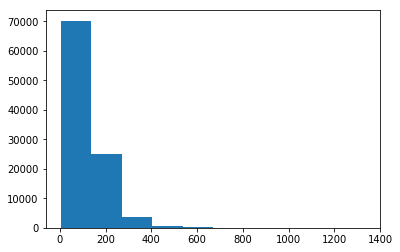

In [37]:
plt.hist(lens)

In [32]:
example = 'Po wybuchu II wojny światowej 1939 podczas kampanii wrześniowej sprawował stanowisko dowódcy 78 pułku piechoty.'
cp.transform_text(example)

'po wybuchu ii wojny światowej podczas kampanii wrześniowej sprawował stanowisko dowódcy pułku piechoty'

In [ ]:
        self.dictionary = OrderedDict()
        self.corpus_path = corpus_path
        with open(corpus_path, 'r') as corpus:
            for line in corpus:
                self.dictionary[]

In [13]:
double_spaces = re.compile('\s+')
re.sub(double_spaces, ' ', 'afs  41 2 5$#sa 24 Sfw15 gw g4gfdsaf j')

'afs 41 2 5$#sa 24 Sfw15 gw g4gfdsaf j'